## Initialization

In [2]:
%% Author: Lu, Chia-Feng 2013.11.01
clear, close all

%% initialize parameters
samplerate=500; % in Hz

segmentNo=20; % for Welch method

## Load Data

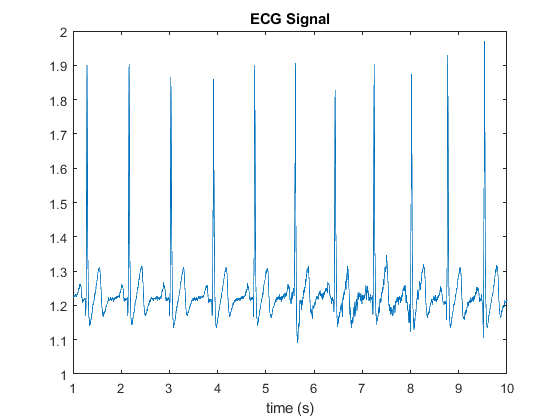

In [4]:
%% load ECG data 
load('ECG_500SampleRate.txt')
data=ECG_500SampleRate;
clear ECG_500SampleRate

N=length(data);
figure,plot([1:N]/samplerate,data),xlim([1 10])
xlabel('time (s)')
title('ECG Signal')

## 3 Detect R peak

* Get R peak using the event detection method
* Get HRV from R-R interval 

In [6]:
%% detect R peak and store R-R interval
%%% perform double-threshold method to detect R peak
% threshold 1: magnitude
indmag=find(data>=1.5);    % find the index with value larger than 1.5

% threshold 2: define window
diffind=indmag(2:end)-indmag(1:end-1);
indgap=find(diffind>1);

indmax=[];   % the location of index with maximal value in each cycle
for i=1:length(indgap)+1
    if i==1
        period=indmag(1:indgap(1));
    elseif i==length(indgap)+1    
        period=indmag(indgap(i-1)+1:end);
    else
        period=indmag(indgap(i-1)+1:indgap(i));
    end
    [value,ind]=max(data(period));
    indmax(i)=period(ind(1));
end

indmax(end)=[];
RRinterval=[];  % heart rate variability (HRV)
RRinterval=diff(indmax)/samplerate;
HRV=60./RRinterval;

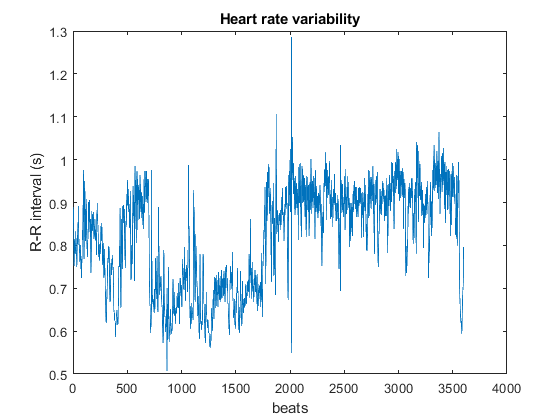

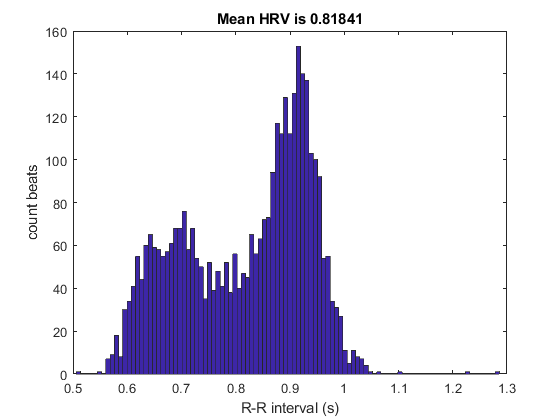

In [9]:
%% rewrite data set by HRV
data=RRinterval; 
% data=HRV; 
samplerate=1/mean(RRinterval);
N=length(RRinterval);

figure,plot(data),title('Heart rate variability')
xlabel('beats'),ylabel('R-R interval (s)')
figure,hist(data,100),title(['Mean HRV is ' num2str(mean(data)) ])
xlabel('R-R interval (s)'),ylabel('count beats')

## FFT analysis

* Use newpower2() function to optimize FFT calculation.
* In frequency domain the maxium frequency is half sample rate.


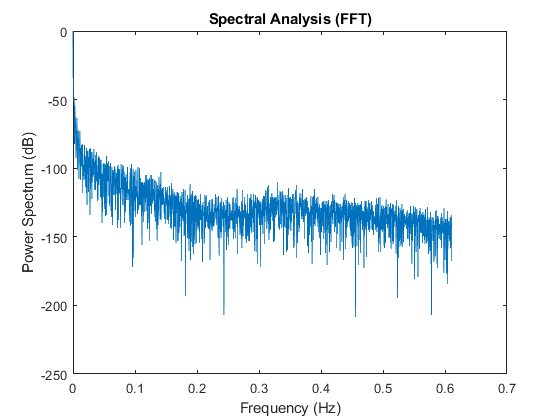

In [9]:
%% Spectral analysis (FFT)
nfft = 2^nextpow2(N); % Next power of 2 from length of y
data_freq=fft(data,nfft);
PS=abs(data_freq).^2;
PS=PS/max(PS);
faxis=linspace(0,1,nfft/2+1)*samplerate/2;

figure,
plot(faxis,20*log10(PS(1:nfft/2+1)))
% plot(faxis,PS(1:nfft/2+1))
title('Spectral Analysis (FFT)')
xlabel('Frequency (Hz)')
ylabel('Power Spectrum (dB)')

### Welch method

Sooth the signal in the frequency domin, like the moving window method in time domin to smooth the signal.

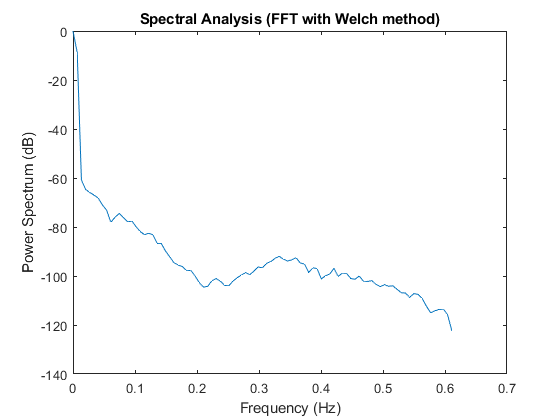

In [11]:
%% Spectral analysis (FFT with Welch method)
windowlength=round(N/segmentNo);
[PS_W,faxis_W] = pwelch(data,hamming(windowlength),[],windowlength,samplerate);
PS_W=PS_W/max(PS_W);

figure,
plot(faxis_W,20*log10(PS_W))
% plot(faxis_W,PS_W)
title('Spectral Analysis (FFT with Welch method)')
xlabel('Frequency (Hz)')
ylabel('Power Spectrum (dB)')

In [10]:
help pwelch

 PWELCH Power Spectral Density estimate via Welch's method.
    Pxx = PWELCH(X) returns the Power Spectral Density (PSD) estimate, Pxx,
    of a discrete-time signal, X, using Welch's averaged, modified
    periodogram method.  When X is a vector, it is converted to a column
    vector and treated as a single channel.  When X is a matrix, the PSD is
    computed independently for each column and stored in the corresponding
    column of Pxx.
 
    By default, X is divided into the longest possible sections, to get as
    close to but not exceeding 8 segments with 50% overlap. A modified
    periodogram is computed for each segment using a Hamming window and all
    the resulting periodograms are averaged to compute the final spectral
    estimate. X is truncated if it cannot be divided into an integer number
    of segments.
 
    Pxx is the distribution of power per unit frequency. For real signals,
    PWELCH returns the one-sided PSD by default; for complex signals, it
    returns t